# Living off the Dividend

While talking about investing and dividends, my friend casually said "The dream is to have so much $VOO I can pay my living expenses with just dividends". Conversation ensued about how many shares of our favorite ETF (Vanguard S&P 500 ETF) one would need to make that possible, and between my interest in investing and data skills, I decided to find the answer.

### Imports

In [1]:
from bs4 import BeautifulSoup
import requests

import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib.pyplot import figure

import datetime
from datetime import timedelta

import numpy as np

import random

### Creating 'global variables', like constants

In [2]:
YEARS_TO_EXTRAPOLATE = 25 # number of years I want to look forward
QUARTERS_TO_EXTRAPOLATE = YEARS_TO_EXTRAPOLATE*4
CURRENT_AGE = (datetime.datetime(2021, 3, 28) - datetime.datetime(1998, 11, 9)).days/365.25 # capturing current age
STARTING_SHARES_HELD = 33 # shares held as of Q1 2021
SHARES_TO_BUY_EVERY_QUARTER = 8 # number of shares to buy every quarter

RENT_OPTIONS_EVERY_QUARTER = [4500, 6000, 7500, 9000] # rental amounts to pay over a quarter ($1500/month = 4500 a quarter)

### Reading in Dividend Data with Pandas

In [3]:
voo_div_history = pd.read_csv('voo_divs.csv') # data from https://www.dividendchannel.com/symbol/voo/
voo_div_history = voo_div_history.iloc[::-1] # reversing csv to fit cronology

### Charting how much dividend Vanguard has paid out per quarter for shareholders of $VOO

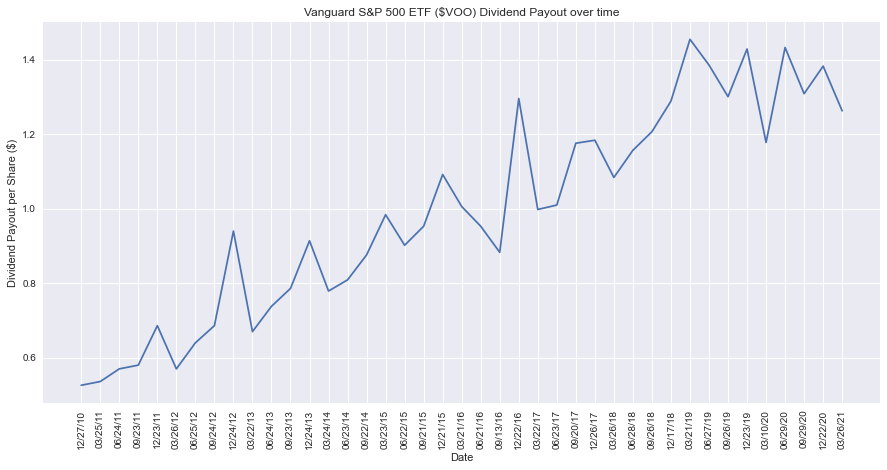

In [6]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(voo_div_history.Date, voo_div_history.Div);
ax.set_xticklabels(voo_div_history.Date, rotation= 90)
ax.set_xlabel("Date")
ax.set_ylabel("Dividend Payout per Share ($)")
ax.set_title("Vanguard S&P 500 ETF ($VOO) Dividend Payout over time");

### Building a Percent Change Column to predict future Dividends

In [8]:
percent_change = []
for index in range(len(voo_div_history.Div)):
    if index != 0:
        new = voo_div_history.Div.tolist()[index]
        old = voo_div_history.Div.tolist()[index-1]
        percent_change.append((new-old)/(old))
    else:
        percent_change.append(0)

In [9]:
voo_div_history['percent_change'] = percent_change

In [10]:
quarterly_growth = voo_div_history.percent_change.median()

#### Turns out the median growth rate for dividends per quarter is 0.04, or 4%

### Charting percent change in dividend payout

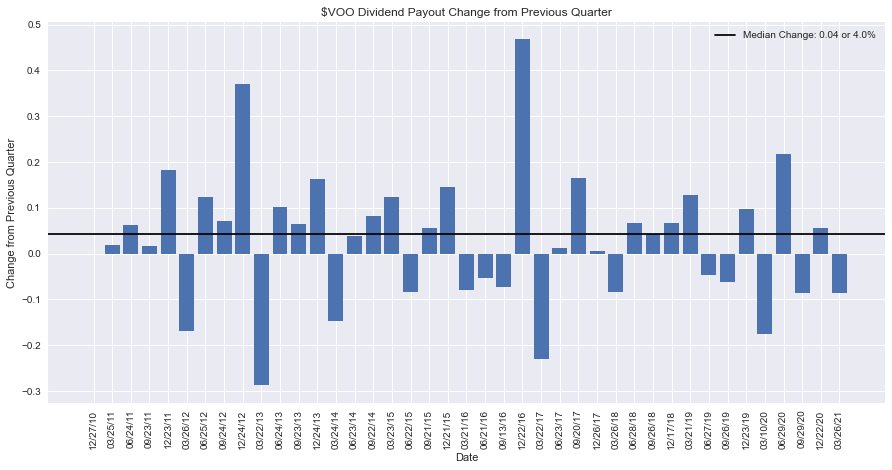

In [17]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(voo_div_history.Date, voo_div_history.percent_change)
ax.axhline(quarterly_growth, color='black', label= "Median Change: {} or {}%".format(round(quarterly_growth, 2),round(quarterly_growth, 2)*100))
ax.set_xticklabels(voo_div_history.Date, rotation= 90)
ax.set_xlabel("Date")
ax.set_ylabel("Change from Previous Quarter")
ax.set_title("$VOO Dividend Payout Change from Previous Quarter")
ax.legend();

### Building lists to eventually create a Pandas DataFrame

In [18]:
quarters_after_Q1_21 = [0] # starting point is 2021 Q1, since 
approx_date = [datetime.datetime(2021, 3, 28)] # dividends are paid out at the end of every 3rd month
age = [CURRENT_AGE] # wanted to track age
dividend_payout_per_share = [1.263] # tracking dividend payout starting Q1 2021, and growing every quarter at 4%
shares_held = [STARTING_SHARES_HELD] # how many shares my friend has today

In [19]:
# incrementing quarter's after Q1 2021
for quarter_num in range(QUARTERS_TO_EXTRAPOLATE):
    quarters_after_Q1_21.append(quarter_num+1)
    
# incrementing approx date of every payout
for count in range(QUARTERS_TO_EXTRAPOLATE):
    approx_date.append(approx_date[-1] + datetime.timedelta(days=90)) # 90 days is the approx length of one quarter 
    
# incrementing age at the time of every dividend payout
for count in range(QUARTERS_TO_EXTRAPOLATE):
    age.append(age[-1] + 0.25) # age increases by 0.25 every quarter
    
# tracking dividend every quarter, which grows at a median rate of 4%
for count in range(QUARTERS_TO_EXTRAPOLATE):
    dividend_payout_per_share.append(dividend_payout_per_share[-1]*(1+quarterly_growth))

# my friend buys 8 shares every quarter
for count in range(QUARTERS_TO_EXTRAPOLATE):
    shares_held.append(shares_held[-1]+SHARES_TO_BUY_EVERY_QUARTER)

In [20]:
# creating dictionary which will eventually be a Pandas Data Frame
raw = {'quarters_after_Q1_21':quarters_after_Q1_21,'approx_date':approx_date,'age':age,'dividend_payout_per_share':dividend_payout_per_share, 'shares_held':shares_held}

In [21]:
# creating Pandas Data Frame
forward = pd.DataFrame(raw)

In [22]:
# calculating total payout every quarter, which is the dividend_payout_per_share * shares_held
forward['total_payout'] = forward.dividend_payout_per_share * forward.shares_held

### Complete DataFrame

In [23]:
forward

,quarters_after_Q1_21,approx_date,age,dividend_payout_per_share,shares_held,total_payout
0,0,2021-03-28,22.38193,1.263000,33,41.679000
1,1,2021-06-26,22.63193,1.317581,41,54.020813
2,2,2021-09-24,22.88193,1.374520,49,67.351497
3,3,2021-12-23,23.13193,1.433921,57,81.733470
4,4,2022-03-23,23.38193,1.495888,65,97.232701
...,...,...,...,...,...,...
96,96,2044-11-22,46.38193,73.332893,801,58739.647588
97,97,2045-02-20,46.63193,76.501990,809,61890.109816
98,98,2045-05-21,46.88193,79.808040,817,65203.168333
99,99,2045-08-19,47.13193,83.256961,825,68686.992747


### Complete Chart

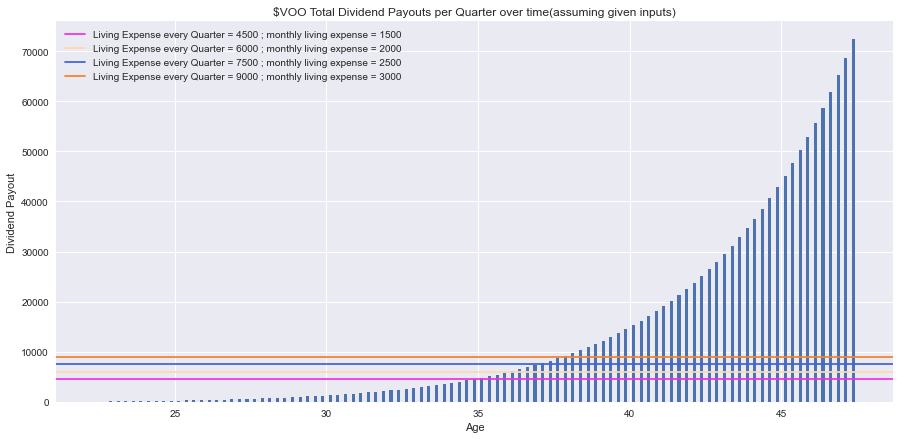

In [24]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(forward.age, forward.total_payout,width=0.1)

ax.set_title("$VOO Total Dividend Payouts per Quarter over time(assuming given inputs)")
ax.set_xlabel("Age")
ax.set_ylabel("Dividend Payout")


random_colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#ffffff', '#000000']
for rent in RENT_OPTIONS_EVERY_QUARTER:
    ax.axhline(rent, color = random.choice(random_colors), label = 'Living Expense every Quarter = {} ; monthly living expense = {}'.format(rent, int(rent/3)))
    

ax.legend();

## He will be able to live off the dividend from mid-late 30's onward @ current rate
#### living expenses not adjusted for inflation, real time frame might be different